In [ ]:
!pip install datasets


In [31]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD

In [38]:
from datasets import load_dataset

ds = load_dataset("microsoft/cats_vs_dogs")

In [39]:
ds = ds["train"].shuffle(seed=42).select(range(2000))  # Случайные 1000 изображений

In [ ]:
ds

In [40]:
def prepare_data(examples):
    images = [np.array(img.convert("RGB").resize((128, 128))) for img in examples['image']]
    labels = examples['labels']
    return {'pixel_values': images, 'labels': labels}

# Apply the transformation to the training set
ds_model = ds.map(prepare_data, batched=True, remove_columns=['image', 'labels'])

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Подготовка данных

In [41]:
X = ds_model['pixel_values']
y = ds_model['labels']

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state=3)

In [44]:
X_train = tf.image.resize(X_train, (32, 32))
X_test = tf.image.resize(X_test, (32, 32)) #изменение размеров картинок для модели

In [45]:
X_train = X_train / 255.0
X_test = X_test / 255.0

In [46]:
X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
X_test = tf.convert_to_tensor(X_test, dtype=tf.float32) #преобразование в tf.Tensor для работы с моделью

In [47]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

In [48]:
datagen.fit(X_train)

In [ ]:
#kernel_regularizer=l2(0.01)

Модель

In [51]:
from tensorflow.keras.layers import Input

inputs = Input(shape=(32, 32, 3))
x = layers.Conv2D(32, (3, 3), activation='relu')(inputs)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
#x = layers.BatchNormalization()(x) #выполняет нормализацию входных данных
x = layers.Conv2D(128, (3, 3), activation='relu')(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.3)(x)#случайным образом выключает 50% нейронов
outputs = layers.Dense(1, activation='sigmoid')(x)

model = Model(inputs=inputs, outputs=outputs)

# Компиляция и обучение модели
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
dataset = dataset.batch(32).prefetch(tf.data.experimental.AUTOTUNE)

model.fit(dataset, epochs=15)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = test_dataset.batch(32)
test_loss, test_acc = model.evaluate(test_dataset)  # Evaluate on test_dataset
print(f"Test accuracy: {test_acc:.4f}")

Epoch 1/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.4775 - loss: 0.6965
Epoch 2/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5204 - loss: 0.6904
Epoch 3/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5557 - loss: 0.6862
Epoch 4/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5915 - loss: 0.6669
Epoch 5/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.6215 - loss: 0.6516
Epoch 6/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.6470 - loss: 0.6328
Epoch 7/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7104 - loss: 0.5552
Epoch 8/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7574 - loss: 0.5144
Epoch 9/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7733 - loss: 0.4819
Epoch 10/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8081 - loss: 0.4322
Epoch 11/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8530 - loss: 0.3479
Epoch 12/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy:

In [ ]:
import numpy as np
print(np.bincount(y_train))
#проверка соотношения количества классов

In [9]:
# Функция для интерполяции изображений до размера 128x128
def upscale_to_128x128(img):
    return np.resize(img, (128, 128))

In [52]:
# Выберем одно изображение для визуализации признаков
img = X_train[0]
img = np.expand_dims(img, axis=0)  # расширим измерения для соответствия входному формату модели

# Получим выходные данные каждого слоя для выбранного изображения
layer_outputs = [layer.output for layer in model.layers]
model.predict(img)

activation_model = Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(img)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


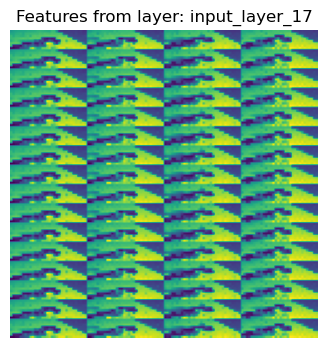

<Figure size 1600x400 with 0 Axes>

<Figure size 1600x400 with 0 Axes>

<Figure size 1600x400 with 0 Axes>

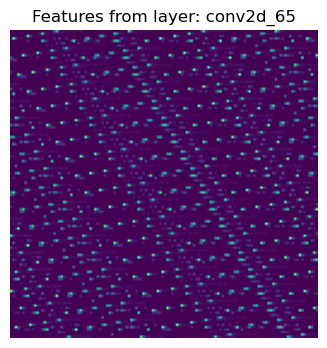

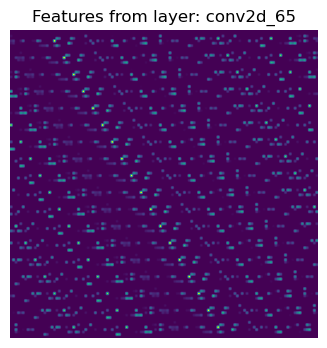

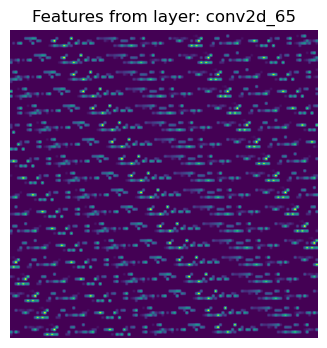

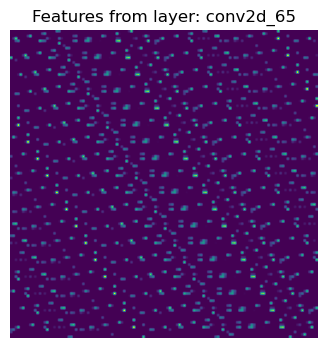

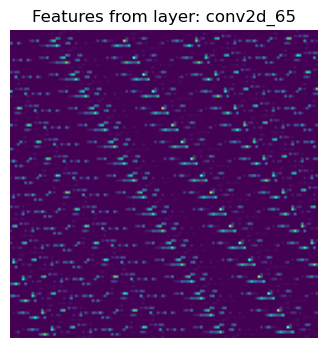

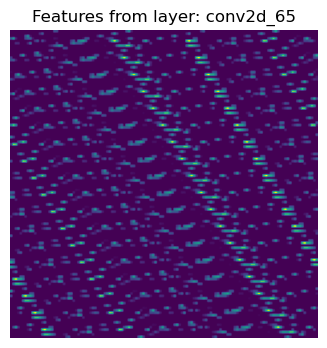

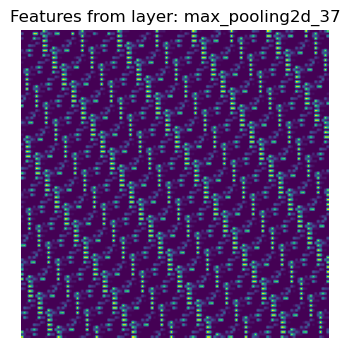

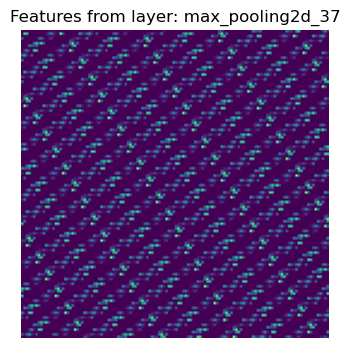

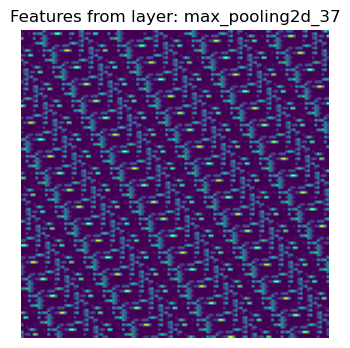

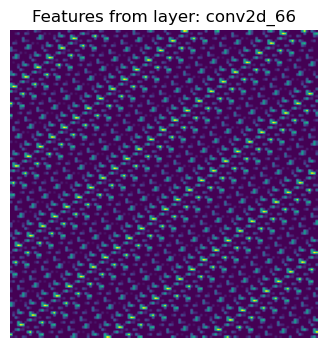

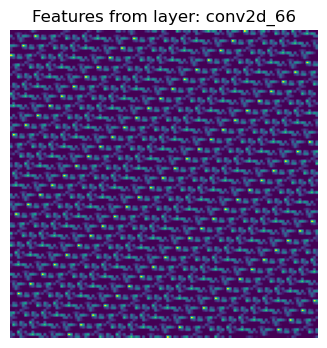

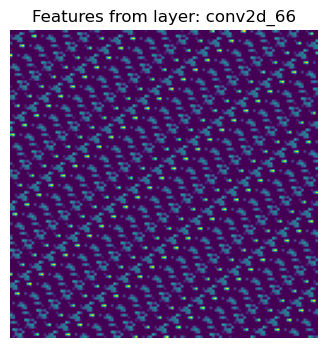

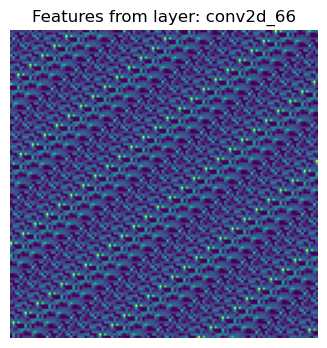

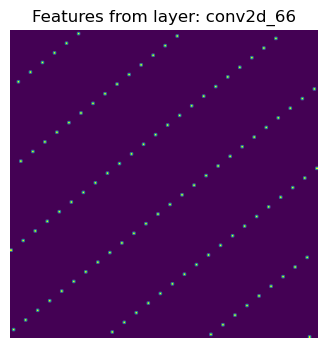

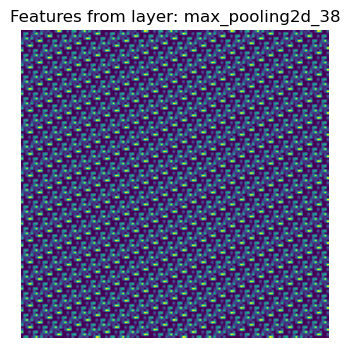

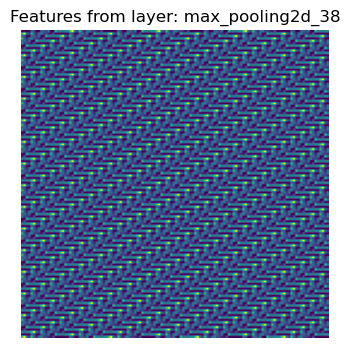

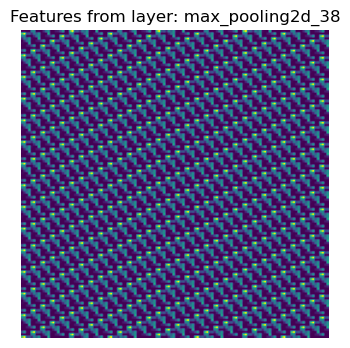

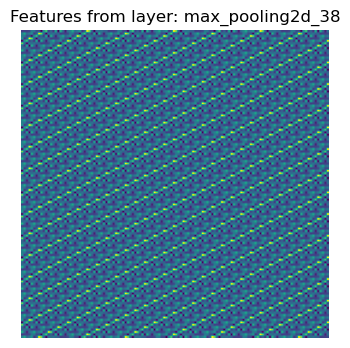

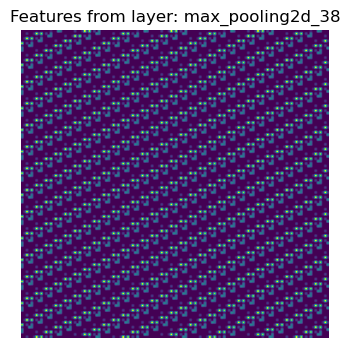

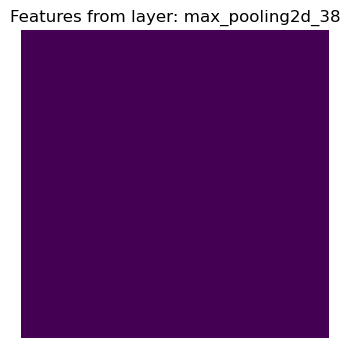

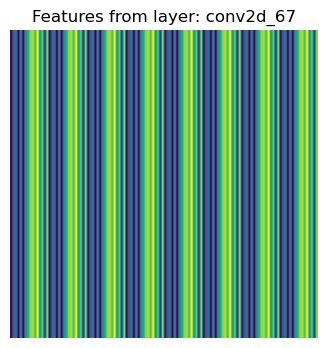

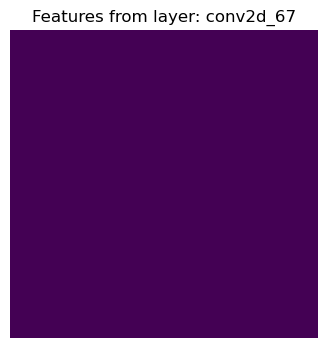

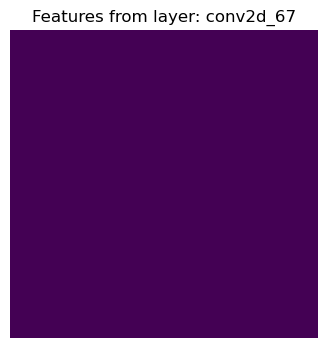

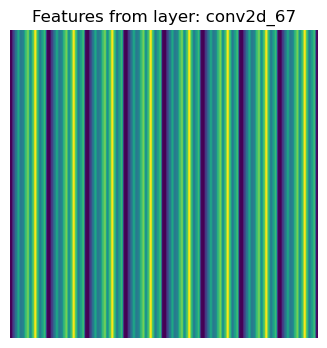

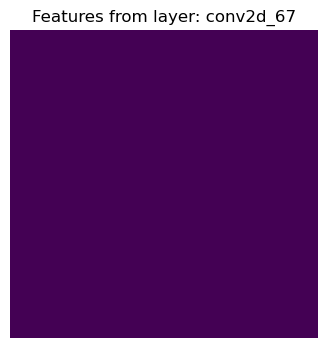

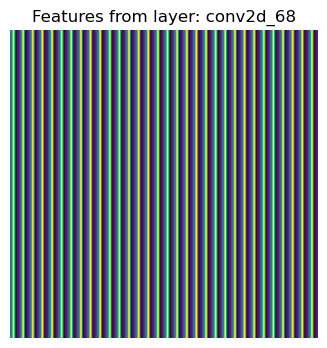

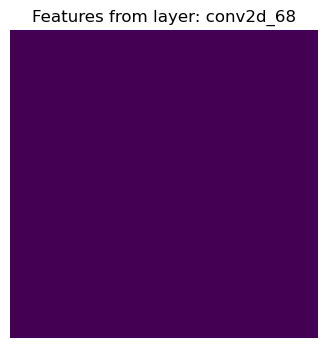

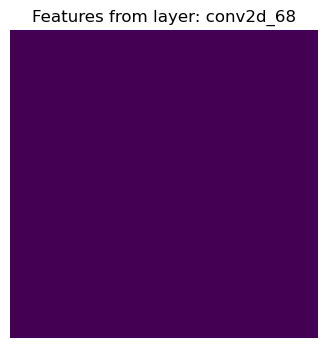

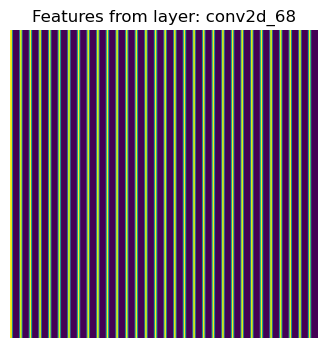

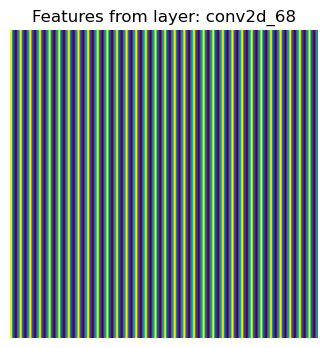

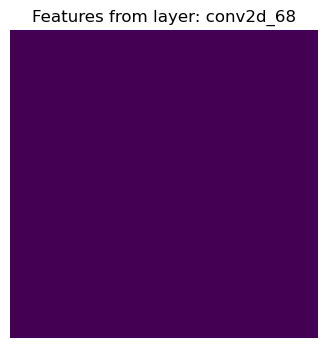

In [53]:
# Визуализация признаков
for layer_name, layer_activation in zip([layer.name for layer in model.layers], activations):
    # Если активация имеет 4 измерения (как в случае с Conv2D и MaxPooling2D)
    if len(layer_activation.shape) == 4:
        # Выберем первые 6 признаковых карт для визуализации
        for i in range(6):
            plt.figure(figsize=(16, 4))
            
            # Некоторые слои могут иметь менее 6 каналов, в таком случае мы визуализируем только имеющиеся
            if layer_activation.shape[-1] >= i+1:
                channel_image = layer_activation[0, :, :, i]
                channel_image = upscale_to_128x128(channel_image)  # Интерполяция до размера 128x128
                plt.imshow(channel_image, cmap='viridis')
                plt.title(f"Features from layer: {layer_name}")
                plt.axis('off')
        plt.show()